# CIFAR-10 Image Classification with PyTorch

This notebook demonstrates how to train Convolutional Neural Networks (CNNs) of varying depths on the CIFAR-10 dataset using PyTorch. We will define, train, and evaluate three different CNN models: a 2-layer (shallow), a 4-layer (mid-depth), and a 6-layer (deep) CNN to observe the effect of network depth on performance.

## 1. Setup and Data Loading

First, we import the necessary libraries for building and training our models, including PyTorch, torchvision for the dataset and transformations, and matplotlib for plotting results.

In [1]:

# Imports
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import time


## 2. Data Preparation

We load the CIFAR-10 dataset, which consists of 60,000 32x32 color images in 10 classes, with 6,000 images per class. There are 50,000 training images and 10,000 test images. We apply transformations to convert the images to tensors and normalize them using the mean and standard deviation of the CIFAR-10 dataset. The data is then loaded into `DataLoader` objects for efficient batch processing.

In [2]:
# Transformations: Convert to tensor and normalize (mean & std for CIFAR-10)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),  # mean
                         (0.2023, 0.1994, 0.2010))  # std
])

# Load training data
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

# Load test data
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

# Define class labels
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


100%|██████████| 170M/170M [00:01<00:00, 106MB/s]


## 3. Model Definition

We define three CNN architectures:

- **ShallowCNN**: A simple network with two convolutional layers.
- **MidCNN**: A network with four convolutional layers.
- **DeepCNN**: A deeper network with six convolutional layers.

All models include pooling layers for downsampling and fully connected layers for classification. A base class `BaseCNN` is used for common utility, though not strictly necessary for this example.

In [3]:
# Base class for CNNs with utility
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()

    def forward(self, x):
        raise NotImplementedError


# 2-layer CNN
class ShallowCNN(BaseCNN):
    def __init__(self):
        super(ShallowCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 4-layer CNN
class MidCNN(BaseCNN):
    def __init__(self):
        super(MidCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# 6-layer CNN
class DeepCNN(BaseCNN):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = x.view(-1, 256 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## 4. Training and Evaluation Setup

We set up the training environment, including specifying the device (GPU if available, otherwise CPU), defining the loss function (Cross-Entropy Loss), and creating a function `train_model` to handle the training and validation loop for a given model and optimizer. This function tracks training and validation accuracy and loss over epochs.

In [4]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Loss and optimizer setup
criterion = nn.CrossEntropyLoss()

# Train and validate for one model
def train_model(model, optimizer, num_epochs=5):
    model.to(device)
    train_acc_list, val_acc_list = [], []
    train_loss_list, val_loss_list = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / len(trainloader.dataset)
        train_acc = 100. * correct / total
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss /= len(testloader.dataset)
        val_acc = 100. * val_correct / val_total
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs} | Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

    return train_acc_list, val_acc_list, train_loss_list, val_loss_list


Using device: cuda


## 5. Model Training

We instantiate each of the three CNN models and define an Adam optimizer for each. We then train each model for 5 epochs using the `train_model` function. The training progress and validation accuracy for each epoch are printed.

In [5]:
# Train ShallowCNN
model_shallow = ShallowCNN()
optimizer_shallow = optim.Adam(model_shallow.parameters(), lr=0.001)
shallow_results = train_model(model_shallow, optimizer_shallow, num_epochs=5)

# Train MidCNN
model_mid = MidCNN()
optimizer_mid = optim.Adam(model_mid.parameters(), lr=0.001)
mid_results = train_model(model_mid, optimizer_mid, num_epochs=5)

# Train DeepCNN
model_deep = DeepCNN()
optimizer_deep = optim.Adam(model_deep.parameters(), lr=0.001)
deep_results = train_model(model_deep, optimizer_deep, num_epochs=5)


Epoch 1/5 | Train Acc: 54.39%, Val Acc: 63.37%
Epoch 2/5 | Train Acc: 67.98%, Val Acc: 67.82%
Epoch 3/5 | Train Acc: 73.51%, Val Acc: 69.96%
Epoch 4/5 | Train Acc: 77.79%, Val Acc: 71.80%
Epoch 5/5 | Train Acc: 81.67%, Val Acc: 71.92%
Epoch 1/5 | Train Acc: 51.14%, Val Acc: 61.11%
Epoch 2/5 | Train Acc: 68.36%, Val Acc: 68.01%
Epoch 3/5 | Train Acc: 75.31%, Val Acc: 73.68%
Epoch 4/5 | Train Acc: 80.56%, Val Acc: 74.26%
Epoch 5/5 | Train Acc: 85.61%, Val Acc: 75.41%
Epoch 1/5 | Train Acc: 42.07%, Val Acc: 56.56%
Epoch 2/5 | Train Acc: 61.86%, Val Acc: 65.06%
Epoch 3/5 | Train Acc: 70.26%, Val Acc: 68.89%
Epoch 4/5 | Train Acc: 75.53%, Val Acc: 71.82%
Epoch 5/5 | Train Acc: 79.15%, Val Acc: 74.09%


## 6. Results Visualization

Finally, we unpack the training results (accuracy and loss for both training and validation sets) for each model. We then generate plots to visualize the validation accuracy and validation loss over the training epochs for all three models, allowing for a comparison of their performance.

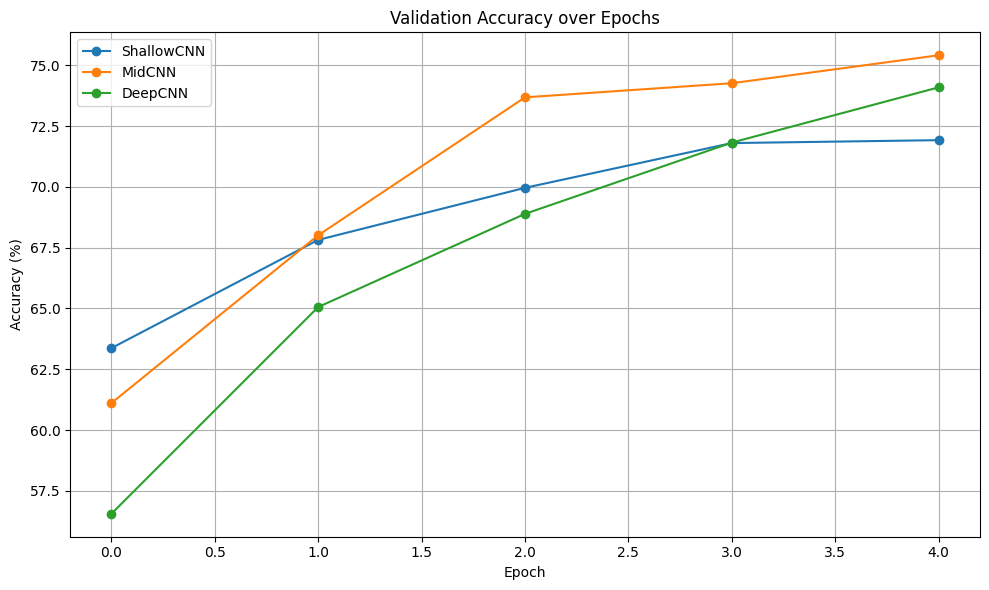

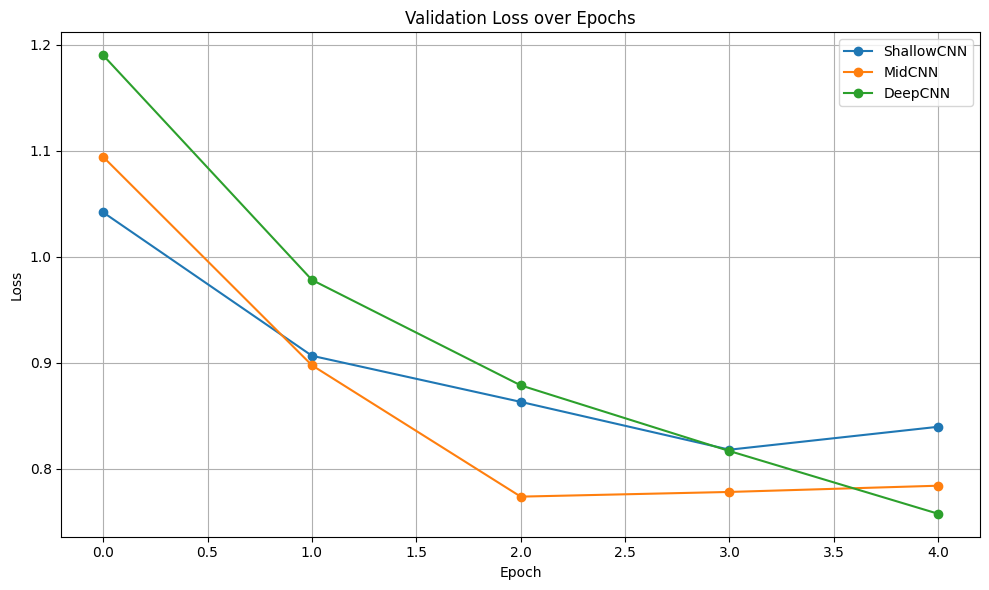

In [6]:
# Unpack results
def unpack(results):
    train_acc, val_acc, train_loss, val_loss = results
    return train_acc, val_acc, train_loss, val_loss

shallow_train_acc, shallow_val_acc, shallow_train_loss, shallow_val_loss = unpack(shallow_results)
mid_train_acc, mid_val_acc, mid_train_loss, mid_val_loss = unpack(mid_results)
deep_train_acc, deep_val_acc, deep_train_loss, deep_val_loss = unpack(deep_results)

# Accuracy Plot
plt.figure(figsize=(10, 6))
plt.plot(shallow_val_acc, label='ShallowCNN', marker='o')
plt.plot(mid_val_acc, label='MidCNN', marker='o')
plt.plot(deep_val_acc, label='DeepCNN', marker='o')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Loss Plot
plt.figure(figsize=(10, 6))
plt.plot(shallow_val_loss, label='ShallowCNN', marker='o')
plt.plot(mid_val_loss, label='MidCNN', marker='o')
plt.plot(deep_val_loss, label='DeepCNN', marker='o')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
